<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Eliminación de Ruido: Ejemplo MNIST</center></span>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Autocodificador o autoencoder](#Autocodificador-o-autoencoder)
* [Importa módulos](#Importa-módulos)
* [Descargar Datos de la Fuente](#Descargar-Datos-de-la-Fuente)
* [Parámetros de la red](#Parámetros-de-la-red)
* [Codificador](#Codificador)
* [Decodificador](#Decodificador)
* [Auto-codificador](#Auto-codificador)
* [Entrenamiento](#Compila)
* [Recuperación de imágenes](#Recuperación-de-imágenes)
* [Representación latente](#Representación-latente)

[[Volver al Inicio]](#Contenido)

## <span style="color:blue">Introducción</span>

En este cuaderno se implementa un Autoencoder Convolucional para la eliminación de ruido usando el conjunto de datos MNIST.

Basado en 

- [Convolutional Autoencoders for Image Noise Reduction](https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763)

- [Convolutional Autoencoder For Image Denoising](https://keras.io/examples/vision/autoencoder/) 

[[Volver al Inicio]](#Contenido)

## <span style="color:blue">Autocodificador o autoencoder</span>

Recordemos un poco el concepto gráfico de lo que significa un autoenconder:

![CAE](https://miro.medium.com/max/2400/1*VYH3i2-2CZ6Fyd7Bv9UHFw.png)

Fuente: [Super-Resolution Using Autoencoders and TF2.0](https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674)

## <span style="color:blue">Importa módulos</span>

In [11]:
# Módulos especificos de tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

#from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# arreglos
import numpy as np

# Manejo de gráficos
import matplotlib.pyplot as plt


In [2]:
np.set_printoptions(linewidth=125)

## <span style="color:blue">Lectura de los datos</span>

In [2]:
# Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normaliza los datos
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

In [3]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
x_train = np.reshape(x_train, newshape=(-1,28,28,1))
x_test = np.reshape(x_test, newshape=(-1,28,28,1))

In [5]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.05098039 0.6901961
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        

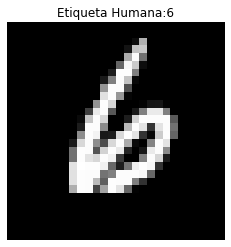

In [6]:
azar=np.random.randint(len(x_train))
print(x_train[azar,:,:,0],'\n')
plt.imshow(x_train[azar,:,:,0],cmap='gray')
plt.title('Etiqueta Humana:'+str(y_train[azar]))
plt.axis('off')
plt.show()

## <span style="color:blue">Añade Ruido</span>

In [12]:
def noise(array):
    """
    Añande ruido a la imagen 
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0) # clip para dejar los valores en [0.0, 1.0]

# Crea una copia de los datos con ruido agregado
noisy_x_train = noise(x_train)
noisy_x_test = noise(x_test)

## <span style="color:blue">Despliega Imágenes </span>

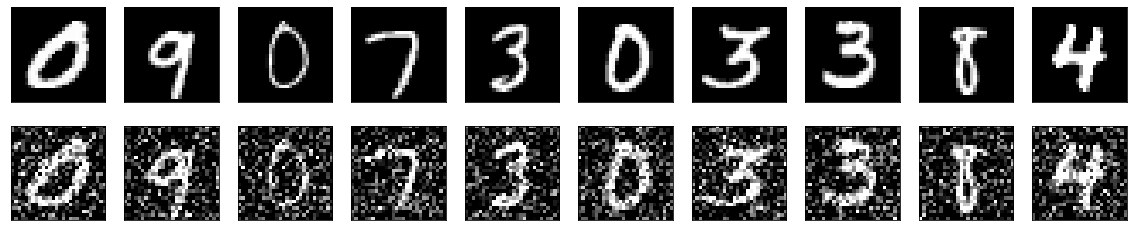

In [13]:
def display(array1, array2):
    """
    Despliega diez imágenes aleatoriamente, de los conjuntos de datos recibidos.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
    

# despliega algunos datos origonales y su versión con ruido
display(x_train, noisy_x_train)    

## <span style="color:blue">Autoenconder Convolucional </span>

In [ ]:
inputs = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

## Entrenar Autoencoder 

In [ ]:
history=autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
)

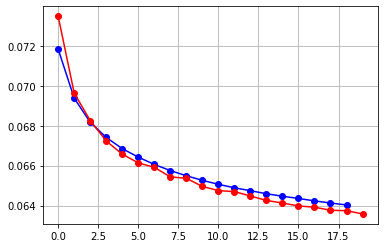

In [16]:
plt.plot(history.history['loss'][1:],'bo-')
plt.plot(history.history['val_loss'][-20:],'ro-')
plt.grid()
plt.show()

## Mostrar Recuperación 

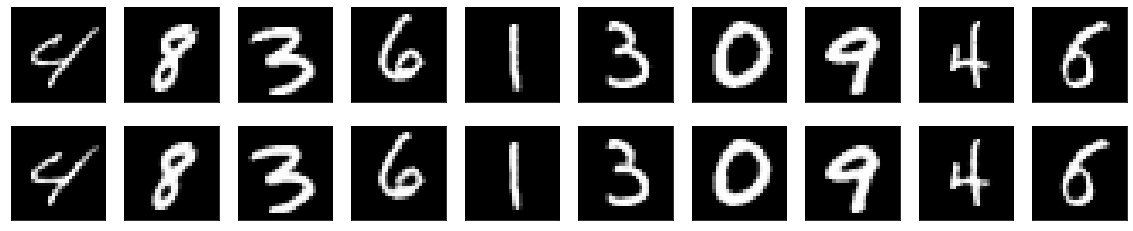

In [17]:
predictions = autoencoder.predict(x_test)
display(x_test, predictions)

## Entrenar Sobre imágenes ruidosas 

In [19]:
autoencoder2 = Model(inputs, x)
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")

In [20]:
history2=autoencoder2.fit(
    x=noisy_x_train,
    y=x_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_x_test, x_test),
)

Epoch 1/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1002 - val_loss: 0.0935
Epoch 2/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0928 - val_loss: 0.0916
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0912 - val_loss: 0.0900
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0903 - val_loss: 0.0893
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0896 - val_loss: 0.0887
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0891 - val_loss: 0.0883
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0887 - val_loss: 0.0880
Epoch 8/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0884 - val_loss: 0.0876
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 10/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0878 - val_lo

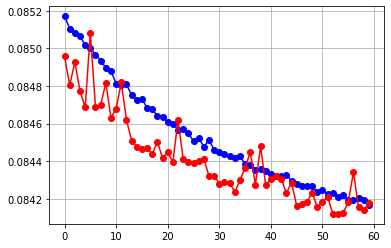

In [22]:
plt.plot(history2.history['loss'][-60:],'bo-')
plt.plot(history2.history['val_loss'][-60:],'ro-')
plt.grid()
plt.show()

## Ver Predicciones

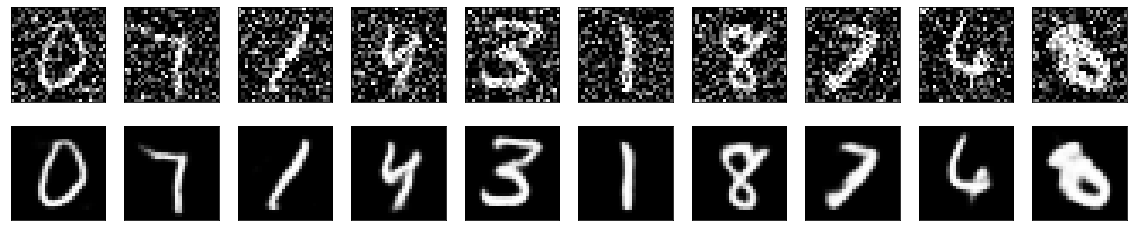

In [23]:
predictions = autoencoder.predict(noisy_x_test)
display(noisy_x_test, predictions)